In [1]:
# Run this once if the packages are not installed yet
# !pip install pillow umap-learn scikit-learn pandas matplotlib


In [2]:
import os
import re
import glob
import tarfile
import csv
import math

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors

# Matches grayscale  "1x1", "32x18"
# and color pixels   "1x1_r", "1x1_g", "1x1_b"
PIXEL_RE = re.compile(r"^\d+x\d+(?:_[rgb])?$")

# Filename pattern for Edinburgh frames
FILENAME_RE = re.compile(
    r"inspacecam163_(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})_(\d{2})\.jpg$"
)


In [3]:
def parse_time_from_filename(name):
    """Returns (hour, minute, second) or None if the filename does not match."""
    base = os.path.basename(name)
    m = FILENAME_RE.match(base)
    if not m:
        return None
    h = int(m.group(4))
    m_ = int(m.group(5))
    s = int(m.group(6))
    return h, m_, s


def seconds_since_midnight(h, m, s):
    return h * 3600 + m * 60 + s


def parse_time_string(s):
    """
    Parse HH:MM or HH:MM:SS -> seconds since midnight.
    """
    parts = s.split(":")
    if len(parts) == 2:
        h, m = parts
        s_val = 0
    elif len(parts) == 3:
        h, m, s_val = parts
    else:
        raise ValueError(f"Invalid time format: {s!r}. Expected HH:MM or HH:MM:SS")
    h_i = int(h)
    m_i = int(m)
    s_i = int(s_val)
    if not (0 <= h_i < 24 and 0 <= m_i < 60 and 0 <= s_i < 60):
        raise ValueError(f"Time out of range: {s!r}")
    return seconds_since_midnight(h_i, m_i, s_i)


def time_filter(day_sec, start_sec, end_sec, use_all_times):
    if use_all_times:
        return True
    return start_sec <= day_sec <= end_sec


In [4]:
def list_tar_files(folder):
    pattern = os.path.join(folder, "day_*.tar")
    tar_paths = sorted(glob.glob(pattern))
    if not tar_paths:
        raise SystemExit(f"No tar files matching 'day_*.tar' found in {folder}")
    return tar_paths


def first_pass_lengths(tar_paths, start_sec, end_sec, use_all_times, frame_step):
    """
    First pass: determine, for each tar, how many kept frames (after subsampling)
    fall into the specified time window (or all times if use_all_times is True).

    Returns:
      - line_index_by_path: {tar_path -> line_id}
      - line_length_by_path: {tar_path -> number_of_kept_frames}
      - global_max_step: maximum step index across all lines
    """
    line_index_by_path = {}
    line_length_by_path = {}
    line_lengths = []

    line_counter = 0

    for path in tar_paths:
        with tarfile.open(path, "r") as tar:
            times = []
            for member in tar.getmembers():
                if not member.isfile():
                    continue
                t = parse_time_from_filename(member.name)
                if t is None:
                    continue
                h, m, s = t
                day_sec = seconds_since_midnight(h, m, s)
                if time_filter(day_sec, start_sec, end_sec, use_all_times):
                    times.append(day_sec)

        times.sort()
        if times:
            kept_len = (len(times) + frame_step - 1) // frame_step
            line_index_by_path[path] = line_counter
            line_length_by_path[path] = kept_len
            line_lengths.append(kept_len)
            line_counter += 1

    if not line_lengths:
        raise SystemExit("No frames found in the specified time window.")

    max_len = max(line_lengths)
    global_max_step = max_len - 1 if max_len > 1 else 0

    return line_index_by_path, line_length_by_path, global_max_step


In [5]:
def build_header(width, height, grayscale):
    header = [
        "id",
        "line",
        "label",
        "step",
        "daytimestamp",
        "daytime",
        "action",
        "age",
        "age_global",
    ]
    # Pixel columns; grayscale: <x>x<y>
    # Color: <x>x<y>_r, <x>x<y>_g, <x>x<y>_b
    for x in range(1, width + 1):
        for y in range(1, height + 1):
            if grayscale:
                header.append(f"{x}x{y}")
            else:
                header.append(f"{x}x{y}_r")
                header.append(f"{x}x{y}_g")
                header.append(f"{x}x{y}_b")
    return header


def extract_pixels(img_fileobj, width, height, grayscale):
    """
    Open image, convert to target mode and size, and return a flat list of values.
    Grayscale: one value per pixel.
    Color: three values (R, G, B) per pixel.
    """
    img = Image.open(img_fileobj)
    if grayscale:
        img = img.convert("L")
    else:
        img = img.convert("RGB")
    img = img.resize((width, height), resample=Image.BILINEAR)

    pixels = img.load()
    values = []
    for x in range(width):         # x = 0..width-1
        for y in range(height):    # y = 0..height-1
            if grayscale:
                values.append(pixels[x, y])
            else:
                r, g, b = pixels[x, y]
                values.extend([r, g, b])
    return values


In [6]:
def second_pass_write_csv(
    tar_paths,
    line_index_by_path,
    line_length_by_path,
    global_max_step,
    start_sec,
    end_sec,
    use_all_times,
    frame_step,
    width,
    height,
    grayscale,
    output_path,
):
    header = build_header(width, height, grayscale)
    global_id = 0
    total_rows = 0

    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for path in tar_paths:
            if path not in line_index_by_path:
                continue  # no frames in window

            line_id = line_index_by_path[path]
            line_len = line_length_by_path[path]

            frames = []
            with tarfile.open(path, "r") as tar:
                for member in tar.getmembers():
                    if not member.isfile():
                        continue
                    t = parse_time_from_filename(member.name)
                    if t is None:
                        continue
                    h, m, s = t
                    day_sec = seconds_since_midnight(h, m, s)
                    if not time_filter(day_sec, start_sec, end_sec, use_all_times):
                        continue
                    time_str = f"{h:02d}:{m:02d}:{s:02d}"
                    frames.append((day_sec, time_str, member))

                frames.sort(key=lambda x: x[0])
                frames = frames[::frame_step]

                for step, (day_sec, time_str, member) in enumerate(frames):
                    if line_len > 1:
                        age = step / (line_len - 1)
                    else:
                        age = 0.0

                    if global_max_step > 0:
                        age_global = step / global_max_step
                    else:
                        age_global = 0.0

                    img_fileobj = tar.extractfile(member)
                    if img_fileobj is None:
                        continue

                    pixel_values = extract_pixels(
                        img_fileobj,
                        width=width,
                        height=height,
                        grayscale=grayscale,
                    )

                    row = [
                        global_id,          # id
                        line_id,            # line (trajectory/day id)
                        "",                 # label
                        step,               # step
                        day_sec,            # daytimestamp
                        time_str,           # daytime
                        "",                 # action
                        f"{age:.6f}",       # age
                        f"{age_global:.6f}" # age_global
                    ] + pixel_values

                    writer.writerow(row)
                    global_id += 1
                    total_rows += 1

    print(f"Wrote {total_rows} rows to {output_path}")


In [7]:
def make_trajectory_filename(
    output_dir,
    width,
    height,
    grayscale,
    use_all_times,
    start_time,
    end_time,
    frame_step,
):
    """
    Create a unique filename for trajectories based on key parameters.
    """
    mode = "gray" if grayscale else "rgb"
    if use_all_times:
        tw = "all"
    else:
        tw = f"{start_time.replace(':','')}-{end_time.replace(':','')}"
    name = f"trajectories_w{width}h{height}_{mode}_tw{tw}_step{frame_step}.csv"
    return os.path.join(output_dir, name)


def build_trajectories_csv(
    folder,
    output_dir=".",
    output_path=None,
    width=128,
    height=72,
    grayscale=True,
    start_time="15:00:00",
    end_time="15:06:59",
    use_all_times=False,
    frame_step=1,
    target_max_samples=None,
):
    """
    Build trajectory CSV from Edinburgh office monitoring tar files.

    Each row = one frame (downsampled image).
    'line' encodes the day/trajectory id, 'step' encodes the time order within line.

    If target_max_samples is given (>0) and frame_step == 1,
    frame_step is chosen automatically so that total kept frames
    are <= target_max_samples (uniform subsampling in time).
    """
    if frame_step <= 0:
        raise ValueError("frame_step must be >= 1")

    os.makedirs(output_dir, exist_ok=True)

    tar_paths = list_tar_files(folder)

    if use_all_times:
        start_sec = 0
        end_sec = 24 * 3600 - 1
    else:
        start_sec = parse_time_string(start_time)
        end_sec = parse_time_string(end_time)
        if end_sec < start_sec:
            raise ValueError("end_time must be >= start_time")

    # Auto-determine frame_step from target_max_samples (no randomness)
    if target_max_samples is not None and target_max_samples > 0 and frame_step == 1:
        # First pass with frame_step=1 to get total frame count
        _, line_length_by_path_full, _ = first_pass_lengths(
            tar_paths,
            start_sec,
            end_sec,
            use_all_times,
            frame_step=1,
        )
        total_frames = sum(line_length_by_path_full.values())
        if total_frames == 0:
            raise SystemExit("No frames found in the specified time window.")

        auto_step = max(1, math.ceil(total_frames / target_max_samples))
        frame_step = auto_step

        print(
            f"Auto frame_step={frame_step} based on target_max_samples={target_max_samples} "
            f"(total base frames={total_frames}, "
            f"approx kept={math.ceil(total_frames / frame_step)})"
        )

    # Decide output filename (includes final frame_step)
    if output_path is None:
        output_path = make_trajectory_filename(
            output_dir=output_dir,
            width=width,
            height=height,
            grayscale=grayscale,
            use_all_times=use_all_times,
            start_time=start_time,
            end_time=end_time,
            frame_step=frame_step,
        )
    else:
        out_dir = os.path.dirname(output_path)
        if out_dir:
            os.makedirs(out_dir, exist_ok=True)

    (
        line_index_by_path,
        line_length_by_path,
        global_max_step,
    ) = first_pass_lengths(
        tar_paths,
        start_sec,
        end_sec,
        use_all_times,
        frame_step,
    )

    print(f"Found {len(line_index_by_path)} trajectories (days)")
    print(
        f"Total kept frames={sum(line_length_by_path.values())} "
        f"with frame_step={frame_step}"
    )

    second_pass_write_csv(
        tar_paths,
        line_index_by_path,
        line_length_by_path,
        global_max_step,
        start_sec,
        end_sec,
        use_all_times,
        frame_step,
        width,
        height,
        grayscale,
        output_path,
    )

    return output_path


In [ ]:
# === GLOBAL CONFIG ===
SEED = 0  # used for UMAP and any deterministic operations

edinburgh_folder = "."   # <- adjust this path
trajectories_output_dir = "trajectories"
embeddings_output_dir   = "embeddings"

# Time window / resolution settings
width = 128
height = 72
grayscale = True       # False = keep RGB
use_all_times = False  # True = ignore time window
start_time = "00:00:00"
end_time   = "23:59:59"

# Subsampling:
# Option A: manual frame_step (ignored if target_max_samples is set and frame_step==1)
frame_step = 10

# Option B: automatic subsampling to aim for <= target_max_samples total frames
target_max_samples = None   # None to disable auto-selection

os.makedirs(trajectories_output_dir, exist_ok=True)
os.makedirs(embeddings_output_dir, exist_ok=True)

traj_csv_path = build_trajectories_csv(
    folder=edinburgh_folder,
    output_dir=trajectories_output_dir,
    width=width,
    height=height,
    grayscale=grayscale,
    start_time=start_time,
    end_time=end_time,
    use_all_times=use_all_times,
    frame_step=frame_step,
    target_max_samples=target_max_samples,
)

print("Trajectory CSV ready:", traj_csv_path)


Auto frame_step=2367 based on target_max_samples=100 (total base frames=236651, approx kept=100)
Found 12 trajectories (days)
Total kept frames=106 with frame_step=2367
Wrote 106 rows to trajectories\trajectories_w128h72_gray_tw000000-235959_step2367.csv
Trajectory CSV ready: trajectories\trajectories_w128h72_gray_tw000000-235959_step2367.csv


In [9]:
df = pd.read_csv(traj_csv_path)
print("Full dataframe shape:", df.shape)
df.head()


Full dataframe shape: (106, 9225)


,id,line,label,step,daytimestamp,daytime,action,age,age_global,1x1,...,128x63,128x64,128x65,128x66,128x67,128x68,128x69,128x70,128x71,128x72
0,0,0,NaN,0,57151,15:52:31,NaN,0.00,0.000000,51,...,49,66,77,44,35,31,23,21,19,18
1,1,0,NaN,1,59800,16:36:40,NaN,0.25,0.076923,115,...,30,41,51,49,66,52,38,35,35,35
2,2,0,NaN,2,62451,17:20:51,NaN,0.50,0.153846,116,...,21,29,37,46,71,57,38,35,36,34
3,3,0,NaN,3,65101,18:05:01,NaN,0.75,0.230769,116,...,18,27,34,46,70,57,39,34,35,34
4,4,0,NaN,4,67752,18:49:12,NaN,1.00,0.307692,102,...,25,31,34,45,64,55,46,46,46,46


In [10]:
def find_pixel_columns(df: pd.DataFrame):
    pixel_cols = [c for c in df.columns if PIXEL_RE.match(c)]
    if not pixel_cols:
        raise SystemExit(
            "No pixel columns found. Expected columns like '1x1', '1x2', "
            "'1x1_r', etc."
        )
    return pixel_cols


# No random subsampling: df_sub is the full trajectory set produced
df_sub = df.copy()

pixel_cols = find_pixel_columns(df_sub)
X = df_sub[pixel_cols].to_numpy(dtype=np.float32)

print("Frames used for UMAP:", len(df_sub))
print("Pixel dim:", X.shape[1])


Frames used for UMAP: 106
Pixel dim: 9216


In [11]:
def compute_quality_metrics(X_high, X_low, n_neighbors=15):
    """
    Compute simple projection quality metrics:
      - trustworthiness
      - kNN overlap (Jaccard over neighbor sets)
    """
    n_samples = X_high.shape[0]
    if n_samples <= 1:
        return {"trustworthiness": np.nan, "knn_overlap": np.nan}

    k = min(n_neighbors, n_samples - 1)

    # Trustworthiness (sklearn implementation)
    tw = trustworthiness(X_high, X_low, n_neighbors=k)

    # kNN overlap
    nn_high = NearestNeighbors(n_neighbors=k + 1, metric="euclidean").fit(X_high)
    nn_low = NearestNeighbors(n_neighbors=k + 1, metric="euclidean").fit(X_low)

    _, idx_high = nn_high.kneighbors(X_high)
    _, idx_low = nn_low.kneighbors(X_low)

    overlaps = []
    for i in range(n_samples):
        hi = set(idx_high[i, 1:])  # drop self
        lo = set(idx_low[i, 1:])
        inter = len(hi & lo)
        union = len(hi | lo)
        if union > 0:
            overlaps.append(inter / union)

    knn_overlap = float(np.mean(overlaps)) if overlaps else np.nan

    return {
        "trustworthiness": float(tw),
        "knn_overlap": knn_overlap,
    }


In [12]:
def make_embedding_filename(
    output_dir,
    traj_csv_path,
    seed,
    n_neighbors,
    min_dist,
    metric,
    n_samples,
):
    """
    Create a unique filename for an embedding based on:
    - base trajectory CSV
    - sample count
    - UMAP params
    - seed
    """
    os.makedirs(output_dir, exist_ok=True)
    base_traj = os.path.splitext(os.path.basename(traj_csv_path))[0]
    md_str = str(min_dist).replace(".", "p")
    metric_str = metric.replace(" ", "_")
    name = (
        f"{base_traj}_samples{n_samples}_metric{metric_str}"
        f"_nn{n_neighbors}_md{md_str}_seed{seed}.npy"
    )
    return os.path.join(output_dir, name)


def run_umap_grid(
    X,
    n_neighbors_list,
    min_dist_list,
    metric,
    random_state,
    quality_k,
    traj_csv_path,
    embeddings_dir,
):
    """
    Run UMAP for all (n_neighbors, min_dist) combinations.

    For each combo:
      - tries to load an existing embedding from disk (based on params + seed)
      - otherwise runs UMAP, saves the embedding to .npy, and records metrics.

    Returns:
      - results_df: one row per combo with metrics
      - embeddings: {(n_neighbors, min_dist) -> (N, 2) array}
    """
    os.makedirs(embeddings_dir, exist_ok=True)

    results = []
    embeddings = {}
    n_samples = X.shape[0]

    for nn in n_neighbors_list:
        for md in min_dist_list:
            emb_path = make_embedding_filename(
                output_dir=embeddings_dir,
                traj_csv_path=traj_csv_path,
                seed=random_state,
                n_neighbors=nn,
                min_dist=md,
                metric=metric,
                n_samples=n_samples,
            )

            if os.path.exists(emb_path):
                print(f"[CACHE] Loading embedding from {emb_path}")
                emb = np.load(emb_path)
            else:
                print(f"[UMAP] n_neighbors={nn}, min_dist={md} (seed={random_state})")
                reducer = umap.UMAP(
                    n_neighbors=nn,
                    min_dist=md,
                    metric=metric,
                    n_components=2,
                    random_state=random_state,
                )
                emb = reducer.fit_transform(X)
                np.save(emb_path, emb)
                print(f"[SAVE] Stored embedding to {emb_path}")

            metrics = compute_quality_metrics(X, emb, n_neighbors=quality_k)

            embeddings[(nn, md)] = emb
            row = {
                "n_neighbors": nn,
                "min_dist": md,
                "metric": metric,
                "seed": random_state,
                "trustworthiness": metrics["trustworthiness"],
                "knn_overlap": metrics["knn_overlap"],
                "embedding_path": emb_path,
            }
            results.append(row)

    results_df = pd.DataFrame(results)
    return results_df, embeddings


In [13]:
# Define the hyperparameter grid
n_neighbors_list = [5, 15, 50]
min_dist_list    = [0.0, 0.1, 0.5]

metric    = "euclidean"
quality_k = 15

results_df, embeddings = run_umap_grid(
    X,
    n_neighbors_list=n_neighbors_list,
    min_dist_list=min_dist_list,
    metric=metric,
    random_state=SEED,
    quality_k=quality_k,
    traj_csv_path=traj_csv_path,
    embeddings_dir=embeddings_output_dir,
)

# Sort by trustworthiness (descending) for quick inspection
results_df_sorted = results_df.sort_values("trustworthiness", ascending=False)
results_df_sorted


[UMAP] n_neighbors=5, min_dist=0.0 (seed=0)


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn5_md0p0_seed0.npy


c:\Users\Christian\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Christian\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[UMAP] n_neighbors=5, min_dist=0.1 (seed=0)
[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn5_md0p1_seed0.npy


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[UMAP] n_neighbors=5, min_dist=0.5 (seed=0)
[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn5_md0p5_seed0.npy


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[UMAP] n_neighbors=15, min_dist=0.0 (seed=0)


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn15_md0p0_seed0.npy
[UMAP] n_neighbors=15, min_dist=0.1 (seed=0)


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn15_md0p1_seed0.npy
[UMAP] n_neighbors=15, min_dist=0.5 (seed=0)
[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn15_md0p5_seed0.npy


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[UMAP] n_neighbors=50, min_dist=0.0 (seed=0)


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn50_md0p0_seed0.npy
[UMAP] n_neighbors=50, min_dist=0.1 (seed=0)


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn50_md0p1_seed0.npy
[UMAP] n_neighbors=50, min_dist=0.5 (seed=0)


c:\Users\Christian\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Christian\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


[SAVE] Stored embedding to embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_samples106_metriceuclidean_nn50_md0p5_seed0.npy


,n_neighbors,min_dist,metric,seed,trustworthiness,knn_overlap,embedding_path
6,50,0.0,euclidean,0,0.956225,0.533671,embeddings\trajectories_w128h72_gray_tw000000-...
5,15,0.5,euclidean,0,0.954020,0.564156,embeddings\trajectories_w128h72_gray_tw000000-...
4,15,0.1,euclidean,0,0.952974,0.550053,embeddings\trajectories_w128h72_gray_tw000000-...
3,15,0.0,euclidean,0,0.951398,0.546701,embeddings\trajectories_w128h72_gray_tw000000-...
7,50,0.1,euclidean,0,0.942752,0.504682,embeddings\trajectories_w128h72_gray_tw000000-...
8,50,0.5,euclidean,0,0.941040,0.499171,embeddings\trajectories_w128h72_gray_tw000000-...
2,5,0.5,euclidean,0,0.941002,0.506492,embeddings\trajectories_w128h72_gray_tw000000-...
0,5,0.0,euclidean,0,0.936789,0.491055,embeddings\trajectories_w128h72_gray_tw000000-...
1,5,0.1,euclidean,0,0.924066,0.492508,embeddings\trajectories_w128h72_gray_tw000000-...


Saved grid plot to: embeddings\trajectories_w128h72_gray_tw000000-235959_step2367_umap_grid_seed0.png


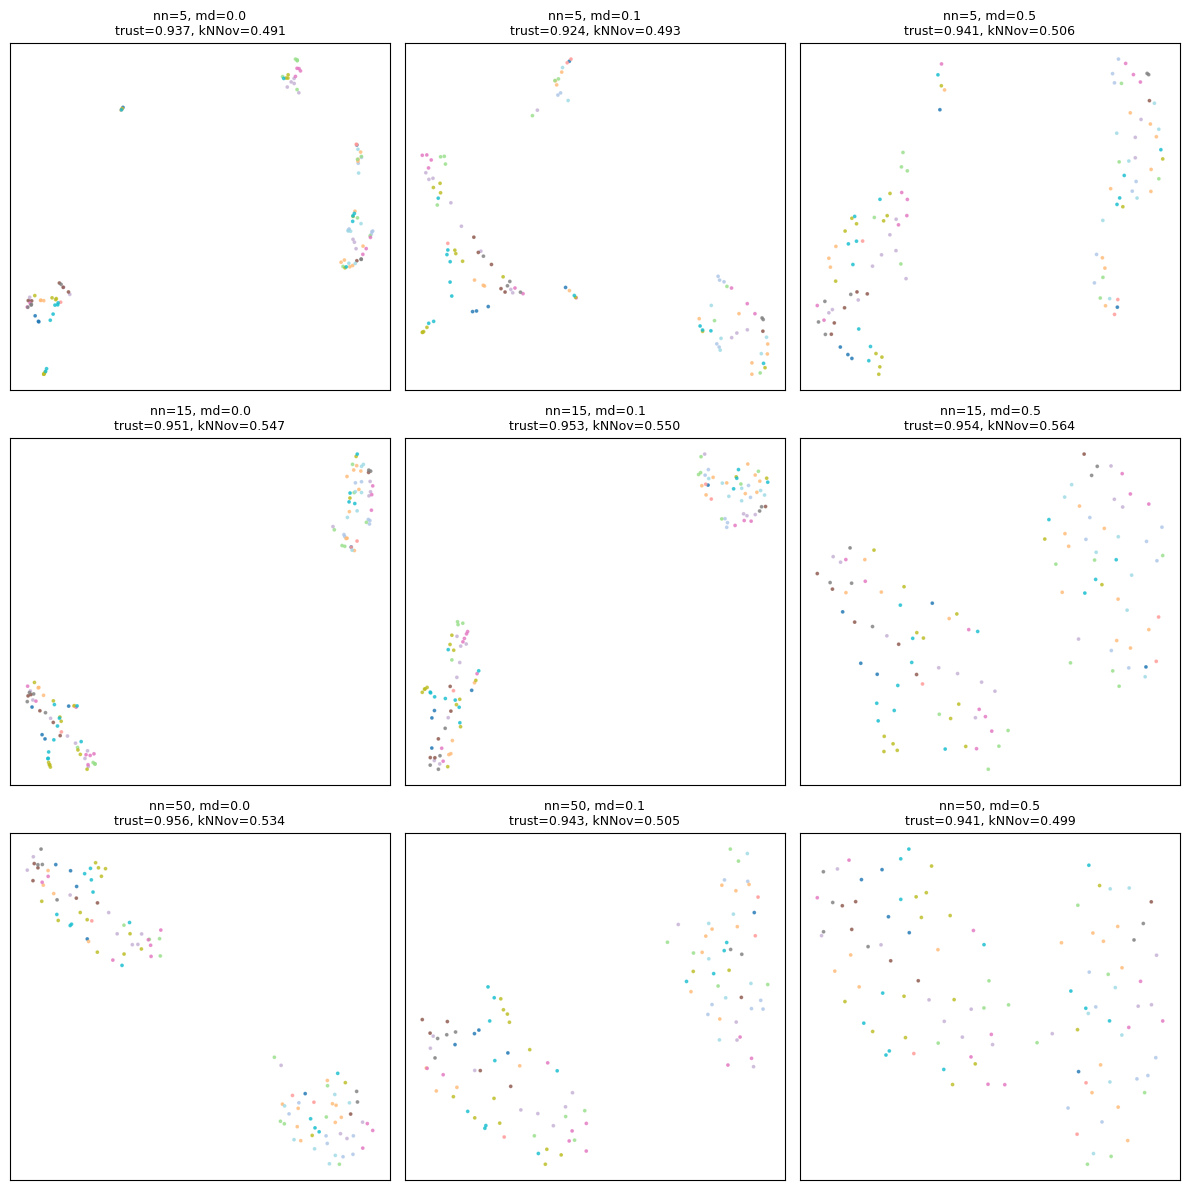

In [14]:
def plot_embedding_grid(
    df_sub,
    embeddings,
    results_df,
    n_neighbors_list,
    min_dist_list,
    figsize_scale=4,
    plot_path=None,
):
    """
    Create a grid of scatterplots:
    rows   = different n_neighbors
    columns= different min_dist
    """
    if "line" not in df_sub.columns:
        raise SystemExit("Column 'line' not found in dataframe; needed for coloring.")

    cat = pd.Categorical(df_sub["line"])
    codes = cat.codes  # 0..K-1

    n_rows = len(n_neighbors_list)
    n_cols = len(min_dist_list)

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(figsize_scale * n_cols, figsize_scale * n_rows),
        squeeze=False,
    )

    for i, nn in enumerate(n_neighbors_list):
        for j, md in enumerate(min_dist_list):
            ax = axes[i, j]
            key = (nn, md)
            if key not in embeddings:
                ax.axis("off")
                continue

            emb = embeddings[key]
            sc = ax.scatter(
                emb[:, 0],
                emb[:, 1],
                c=codes,
                s=3,
                alpha=0.7,
                cmap="tab20",
            )
            ax.set_xticks([])
            ax.set_yticks([])

            match = results_df[
                (results_df["n_neighbors"] == nn)
                & (results_df["min_dist"] == md)
            ]
            if not match.empty:
                row = match.iloc[0]
                title = (
                    f"nn={nn}, md={md}\n"
                    f"trust={row['trustworthiness']:.3f}, "
                    f"kNNov={row['knn_overlap']:.3f}"
                )
            else:
                title = f"nn={nn}, md={md}"
            ax.set_title(title, fontsize=9)

    fig.tight_layout()

    if plot_path is not None:
        fig.savefig(plot_path, dpi=300)

    return fig


base_traj = os.path.splitext(os.path.basename(traj_csv_path))[0]
grid_plot_path = os.path.join(
    embeddings_output_dir,
    f"{base_traj}_umap_grid_seed{SEED}.png",
)

fig = plot_embedding_grid(
    df_sub=df_sub,
    embeddings=embeddings,
    results_df=results_df,
    n_neighbors_list=n_neighbors_list,
    min_dist_list=min_dist_list,
    figsize_scale=4,
    plot_path=grid_plot_path,
)

print("Saved grid plot to:", grid_plot_path)


In [15]:
# Save ALL UMAP configs as CSV + per-config PNG scatterplots
# Names encode: trajectory CSV, sample count, metric, n_neighbors, min_dist, seed

n_samples = X.shape[0]

if "line" not in df_sub.columns:
    raise SystemExit("Column 'line' not found in df_sub; needed for coloring.")

cat = pd.Categorical(df_sub["line"])
codes = cat.codes  # 0..K-1

saved_count = 0

for (nn, md), emb in embeddings.items():
    # Reconstruct the embedding base filename (same as used in run_umap_grid)
    emb_path = make_embedding_filename(
        output_dir=embeddings_output_dir,
        traj_csv_path=traj_csv_path,
        seed=SEED,
        n_neighbors=nn,
        min_dist=md,
        metric=metric,
        n_samples=n_samples,
    )

    csv_path = emb_path.replace(".npy", ".csv")
    png_path = emb_path.replace(".npy", ".png")

    # 1) Save CSV with x,y attached
    df_emb = df_sub.copy()
    df_emb["x"] = emb[:, 0]
    df_emb["y"] = emb[:, 1]
    df_emb.to_csv(csv_path, index=False)

    # 2) Save per-config scatterplot
    fig, ax = plt.subplots(figsize=(6, 5))
    sc = ax.scatter(
        emb[:, 0],
        emb[:, 1],
        c=codes,
        s=3,
        alpha=0.7,
        cmap="tab20",
    )
    ax.set_xlabel("x (UMAP)")
    ax.set_ylabel("y (UMAP)")

    row = results_df[
        (results_df["n_neighbors"] == nn)
        & (results_df["min_dist"] == md)
    ]
    if not row.empty:
        r = row.iloc[0]
        title = (
            f"nn={nn}, md={md}, seed={int(r['seed'])}\n"
            f"trust={r['trustworthiness']:.3f}, "
            f"kNNov={r['knn_overlap']:.3f}"
        )
    else:
        title = f"nn={nn}, md={md}, seed={SEED}"
    ax.set_title(title, fontsize=9)

    plt.tight_layout()
    fig.savefig(png_path, dpi=300)
    plt.close(fig)

    saved_count += 1

print(
    f"Saved CSV + PNG for {saved_count} UMAP configurations in '{embeddings_output_dir}'."
)


Saved CSV + PNG for 9 UMAP configurations in 'embeddings'.
